In [1]:
# Load in the dataset
import pandas as pd

database_path = "../database/game_stats.db"
df = pd.read_sql_table("game_stats", f"sqlite:///{database_path}")
print(df.shape)
df.head()

(4390, 28)


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42024,1610612760,OKC,Oklahoma City Thunder,0042400407,2025-06-22,OKC vs. IND,W,240,103,...,0.710,13,27,40,20,14,8,7,23,12.0
1,42024,1610612754,IND,Indiana Pacers,0042400407,2025-06-22,IND @ OKC,L,240,91,...,0.759,12,33,45,17,6,4,21,24,-12.0
2,42024,1610612754,IND,Indiana Pacers,0042400406,2025-06-19,IND vs. OKC,W,240,108,...,0.680,11,35,46,23,16,5,10,17,17.0
3,42024,1610612760,OKC,Oklahoma City Thunder,0042400406,2025-06-19,OKC @ IND,L,240,91,...,0.808,4,37,41,14,4,4,21,20,-17.0
4,42024,1610612754,IND,Indiana Pacers,0042400405,2025-06-16,IND @ OKC,L,241,109,...,0.800,18,32,50,23,9,4,22,25,-11.0


In [2]:
# Drop unwanted columns and replace categorical data with numerical labels
df.drop(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'MIN'], axis=1, inplace=True)
df.replace({'L':0, 'W':1}, inplace=True)
df.head()

C:\Users\gthra\AppData\Local\Temp\ipykernel_21716\1764385072.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'L':0, 'W':1}, inplace=True)


,WL,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,1,103,35,87,0.402,11,40,0.275,22,31,0.710,13,27,40,20,14,8,7,23,12.0
1,0,91,29,70,0.414,11,28,0.393,22,29,0.759,12,33,45,17,6,4,21,24,-12.0
2,1,108,38,92,0.413,15,42,0.357,17,25,0.680,11,35,46,23,16,5,10,17,17.0
3,0,91,31,74,0.419,8,30,0.267,21,26,0.808,4,37,41,14,4,4,21,20,-17.0
4,0,109,37,82,0.451,11,30,0.367,24,30,0.800,18,32,50,23,9,4,22,25,-11.0


In [3]:
# Split the dataset into its inputs (X) and outputs (y) 
X = df.drop('WL', axis=1)
y = df['WL']
col_names = list(X.columns)
print(col_names)

['PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']


In [4]:
# Split data into train, val, and test subdatasets and scale features 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seed = 42
test_size_ratio = .15
eval_size_ratio = .15 / (1-test_size_ratio)

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=test_size_ratio, random_state=seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=eval_size_ratio, random_state=seed)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval), columns=X.columns)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_eval = pd.DataFrame(y_eval)

In [5]:
# Impute any NAs with the mean of the feature which is 0 based on the standard scaling that was done previously
import numpy as np
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)
X_eval.fillna(0,inplace=True)

In [6]:
# Defined functions that create and display a heatmap and correlation matrix as well as a function that drops redundant features from a dataset
import seaborn as sns
import matplotlib.pyplot as plt

def display_heatmap(matrix, title, xlabel, ylabel, cmap='bwr'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt=".2f")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def correlation_matrix(dataframe, threshold_mag=None, lower=False, k=0, plot_corr=False, xlabel=None, ylabel=None):
    title = "Feature Correlation Matrix"
    corr_matrix = dataframe.corr()
    
    if threshold_mag:
        corr_matrix *= (abs(corr_matrix) >= threshold_mag)
        corr_matrix = corr_matrix.map(lambda x: 0 if abs(x) < 1e-10 else x)
        title += f" (Threshold Magnitude of {threshold_mag})"
        
    if lower:
        corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=k).astype(bool))
        title = "Lower Triangular " + title
    
    if plot_corr:
        display_heatmap(corr_matrix, title, xlabel, ylabel)
        
    return corr_matrix
        
def get_dropped_features(dataframe, threshold_mag=0.7):
    corr_matrix = correlation_matrix(dataframe=dataframe, threshold_mag=threshold_mag, lower=False, plot_corr=False)
    
    edge_conns = {}
    col_names_df = list(corr_matrix.columns)
    corr_matrix = corr_matrix.values.tolist()
    
    for i in range(len(corr_matrix)):
        num_edge = 0
        nodes_connected_to = set()
        for j in range(len(corr_matrix[i])):
            if j == i:
                continue
            val = corr_matrix[i][j]
            if abs(float(val)) >= 0.7:
                num_edge += 1
                nodes_connected_to.add(col_names_df[j])
        
        if num_edge != 0:
            edge_conns[col_names_df[i]] = [num_edge, nodes_connected_to]
    
    dropped_features = set()
    while edge_conns:
        edge_conns = dict(sorted(edge_conns.items(), key=lambda item: item[1][0], reverse=True))
        safe_node = list(edge_conns.keys())[0]
        newly_dropped_nodes = list(edge_conns[safe_node][1])
        dropped_features.update(newly_dropped_nodes)
        del edge_conns[safe_node]
        
        for dropped_node in newly_dropped_nodes:
            new_num_conn_nodes = edge_conns[dropped_node][0] - 1
            if new_num_conn_nodes == 0:
                del edge_conns[dropped_node]
            else:
                edge_conns[dropped_node] = [new_num_conn_nodes, edge_conns[dropped_node][1].remove(safe_node)]
    
    return dropped_features

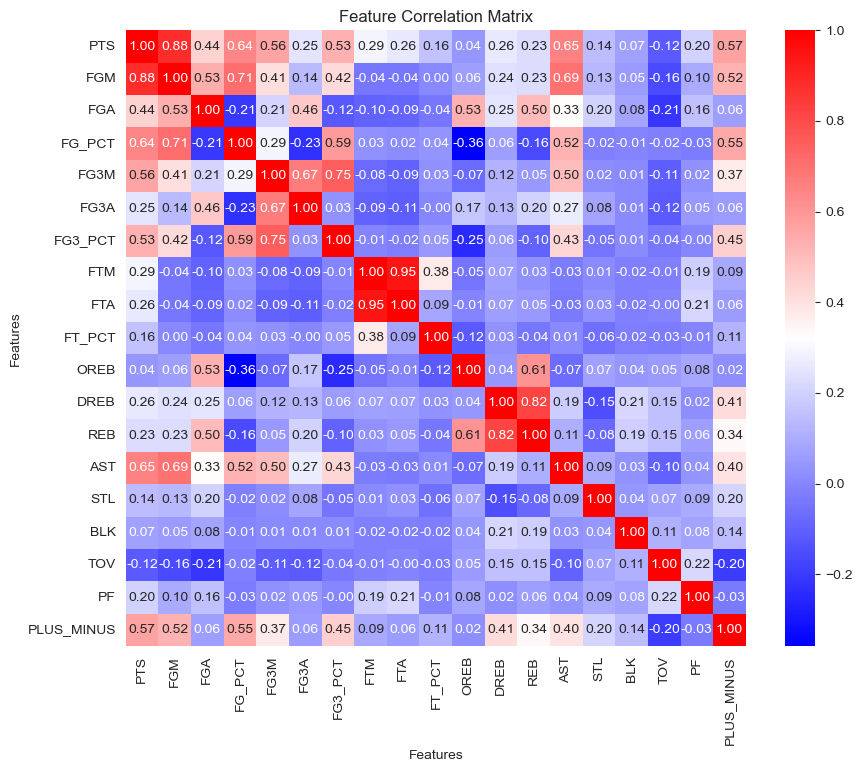

Dropped features (5 total) with threshold magnitude of 0.7: {'PTS', 'FG_PCT', 'REB', 'FG3_PCT', 'FTA'}
Remaining features (14 total): ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']


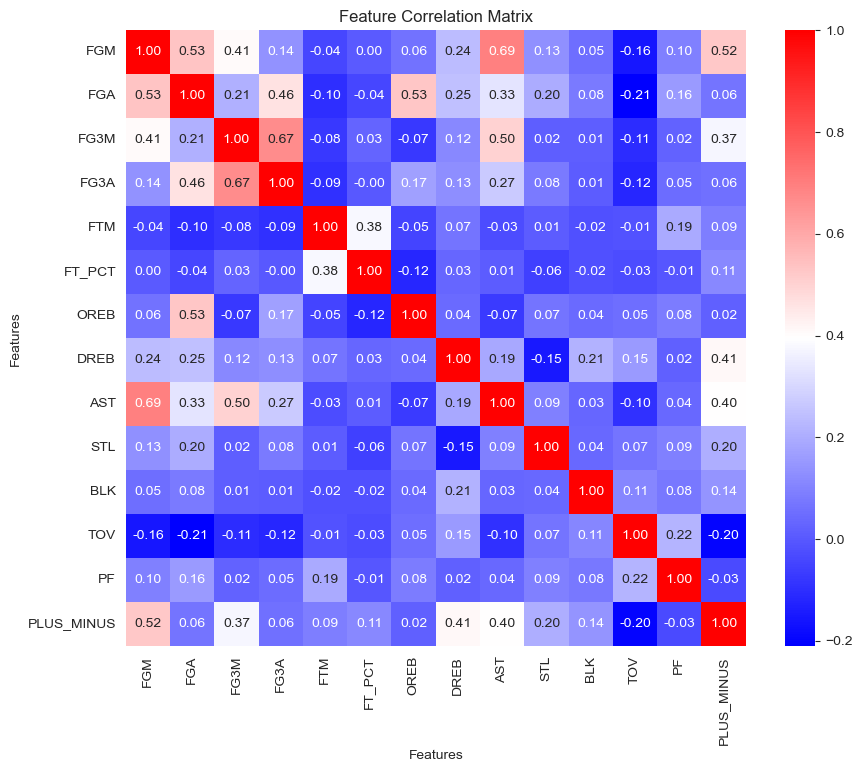

,FGM,FGA,FG3M,FG3A,FTM,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,PLUS_MINUS
FGM,1.000000,0.534360,0.407946,0.136077,-0.041957,0.003255,0.063477,0.237716,0.694893,0.132862,0.053725,-0.158134,0.096653,0.524182
FGA,0.534360,1.000000,0.208656,0.464700,-0.098784,-0.040723,0.529922,0.247322,0.330822,0.200689,0.077943,-0.210583,0.155767,0.063800
FG3M,0.407946,0.208656,1.000000,0.667171,-0.075881,0.026753,-0.073879,0.115571,0.500992,0.015148,0.012072,-0.105030,0.024749,0.374853
FG3A,0.136077,0.464700,0.667171,1.000000,-0.094399,-0.001571,0.170027,0.128120,0.271255,0.080696,0.009087,-0.119684,0.048207,0.056742
FTM,-0.041957,-0.098784,-0.075881,-0.094399,1.000000,0.377103,-0.046178,0.067951,-0.026234,0.008003,-0.017033,-0.014036,0.192246,0.091313
FT_PCT,0.003255,-0.040723,0.026753,-0.001571,0.377103,1.000000,-0.117369,0.032599,0.008084,-0.057613,-0.019844,-0.029153,-0.006573,0.114818
OREB,0.063477,0.529922,-0.073879,0.170027,-0.046178,-0.117369,1.000000,0.040531,-0.070044,0.066247,0.041201,0.049889,0.083806,0.019349
DREB,0.237716,0.247322,0.115571,0.128120,0.067951,0.032599,0.040531,1.000000,0.187534,-0.151201,0.213649,0.153944,0.018696,0.412524
AST,0.694893,0.330822,0.500992,0.271255,-0.026234,0.008084,-0.070044,0.187534,1.000000,0.093814,0.031816,-0.095576,0.035566,0.395455
STL,0.132862,0.200689,0.015148,0.080696,0.008003,-0.057613,0.066247,-0.151201,0.093814,1.000000,0.039949,0.067524,0.094495,0.204290


In [7]:
# Create and display correlation matrix; drop as many redundant features as possible while preserving as much info as possible
threshold_mag = 0.7
correlation_matrix(X_train, threshold_mag=None, lower=False, plot_corr=True, xlabel="Features", ylabel="Features")
dropped_features = get_dropped_features(X_train, threshold_mag=threshold_mag)
print(f"Dropped features ({len(dropped_features)} total) with threshold magnitude of {threshold_mag}: {dropped_features}")
X_train.drop(dropped_features, axis=1, inplace=True)
X_test.drop(dropped_features, axis=1, inplace=True)
X_eval.drop(dropped_features, axis=1, inplace=True)
col_names = [feature for feature in col_names if feature not in dropped_features]
print(f"Remaining features ({len(col_names)} total): {col_names}")
correlation_matrix(X_train, threshold_mag=None, lower=False, plot_corr=True, xlabel="Features", ylabel="Features")

In [8]:
# Fit a PCA to determine how to reduce the number dimensions in the dataset feature space while preserving a certain threshold of explained variance
from sklearn.decomposition import PCA

X_train_idxs = X_train.index
X_test_idxs = X_test.index
X_eval_idxs = X_eval.index

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_eval = pca.transform(X_eval)

n_components = X_train.shape[1]
pc_columns = [f'PC{i+1}' for i in range(n_components)]
X_train = pd.DataFrame(X_train, columns=pc_columns, index=X_train_idxs)
X_test = pd.DataFrame(X_test, columns=pc_columns, index=X_test_idxs)
X_eval = pd.DataFrame(X_eval, columns=pc_columns, index=X_eval_idxs)

In [10]:
# Defined function to display bar graphs
def display_bar_graph(x_vals, y_vals, title, xlabel, ylabel):
    plt.bar(x_vals, y_vals)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(title)
    plt.show()

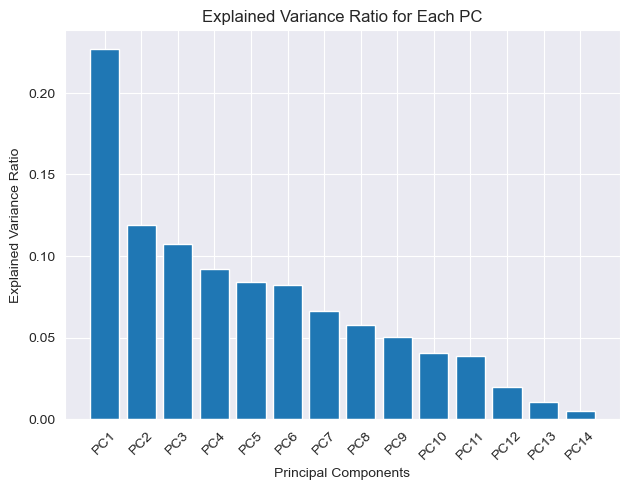

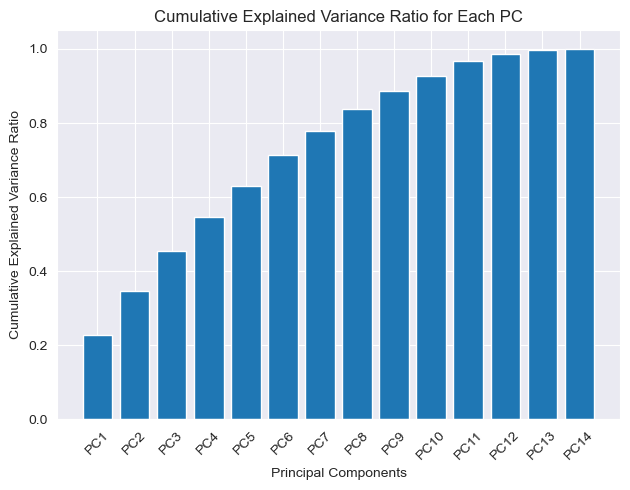

In [11]:
# Displaying the explained variance ratio and cumulative explained variance ratio for each PC
display_bar_graph(pc_columns, pca.explained_variance_ratio_, "Explained Variance Ratio for Each PC", "Principal Components", "Explained Variance Ratio")
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
display_bar_graph(pc_columns, cumulative_variance, "Cumulative Explained Variance Ratio for Each PC", "Principal Components", "Cumulative Explained Variance Ratio")

In [12]:
# Get the PCs to keep that explain a minimum of a certain threshold of variance
def calc_last_pc_idx_to_keep(cumulative_variance, threshold_var_explained):
    over_threshold_var_explained = cumulative_variance - threshold_var_explained
    for i in range(len(over_threshold_var_explained)):
        if over_threshold_var_explained[i] >= 0:
            return i
        
    return len(over_threshold_var_explained) - 1

threshold_var_explained = 0.9
last_pc_idx = calc_last_pc_idx_to_keep(cumulative_variance, threshold_var_explained)
print(f"Keeping the first {last_pc_idx+1} PCs as they explain at or above the variance threshold of {100 * threshold_var_explained}% at {round(100 * cumulative_variance[last_pc_idx], 2)}%")

X_train = X_train.iloc[:, :last_pc_idx+1]
X_test = X_test.iloc[:, :last_pc_idx+1]
X_eval = X_eval.iloc[:, :last_pc_idx+1]
print("The shapes of X_train, X_test, and X_eval are, respectively:", X_train.shape, X_test.shape, X_eval.shape)

pc_columns = pc_columns[:last_pc_idx+1]
print(f"Remaining columns ({len(pc_columns)} total): {pc_columns}")

Keeping the first 10 PCs as they explain at or above the variance threshold of 90.0% at 92.65%
The shapes of X_train, X_test, and X_eval are, respectively: (3072, 10) (659, 10) (659, 10)
Remaining columns (10 total): ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


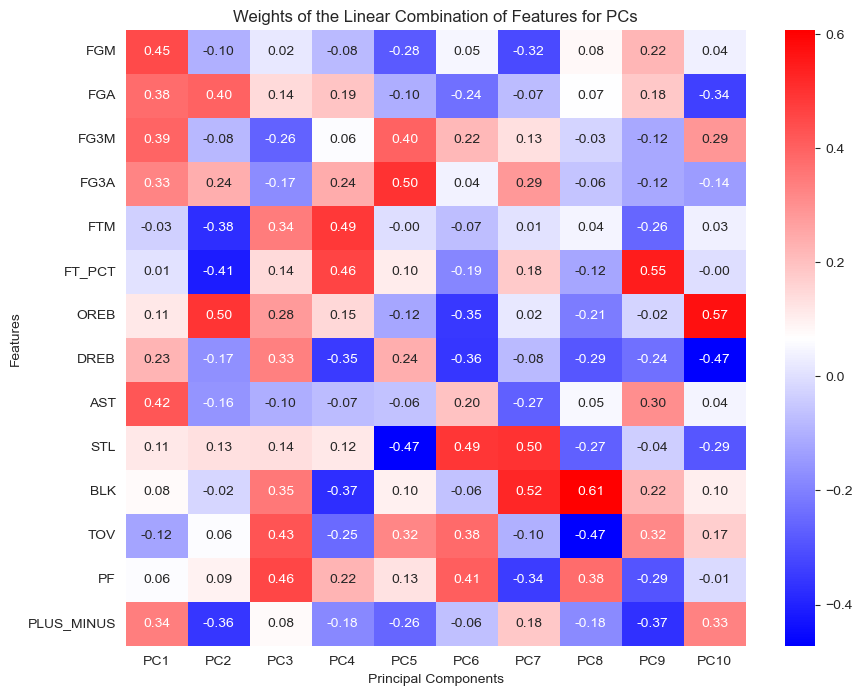

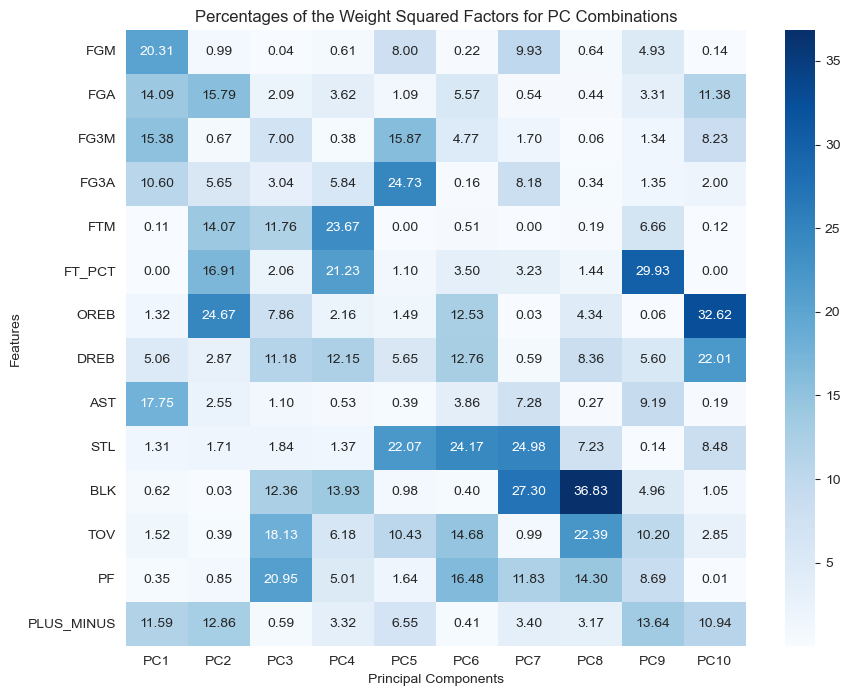

,Global Feature Percentage
STL,7.652895
BLK,7.649974
DREB,7.581346
OREB,7.572764
TOV,7.518497
FGA,7.426491
FG3A,7.282024
PLUS_MINUS,7.184802
FG3M,7.128181
FGM,6.942912


In [13]:
# Display heatmaps and a chart to interpret the results of the PCA transformation done on the dataset
loadings = pd.DataFrame(
    pca.components_.T[:, :last_pc_idx+1],
    index=col_names,
    columns=pc_columns
)

display_heatmap(loadings, "Weights of the Linear Combination of Features for PCs", "Principal Components", "Features")

contributions_percentages = []
for pc in loadings.columns:
    pc_vector = loadings[pc]
    contributions_percentages.append(list(100 * (pc_vector**2) / np.sum(pc_vector**2)))

contributions_percentages = pd.DataFrame(
    np.array(contributions_percentages).T,
    index=col_names,
    columns=pc_columns
)
display_heatmap(contributions_percentages, "Percentages of the Weight Squared Factors for PC Combinations", "Principal Components", "Features", cmap="Blues")

weighted_contributions = (loadings ** 2) * pca.explained_variance_ratio_[:last_pc_idx+1]
global_feature_contributions = weighted_contributions.sum(axis=1)
global_feature_percent = (global_feature_contributions / global_feature_contributions.sum()) * 100
global_feature_percent = pd.DataFrame(
    global_feature_percent.sort_values(ascending=False),
    columns=["Global Feature Percentage"]
)

global_feature_percent

In [ ]:
# Save the following feature engineered datasets to avoid having to rerun the script everytime: X_train, X_test, X_eval, y_train, y_test, and y_eval
import os
import shutil

saved_feature_engineered_data_dir_path = 'feature_engineered_data/'
if os.path.exists(saved_feature_engineered_data_dir_path):
    shutil.rmtree(saved_feature_engineered_data_dir_path)
os.makedirs(saved_feature_engineered_data_dir_path)

X_train.to_parquet(saved_feature_engineered_data_dir_path + "X_train.parquet")
X_test.to_parquet(saved_feature_engineered_data_dir_path + "X_test.parquet")
X_eval.to_parquet(saved_feature_engineered_data_dir_path + "X_eval.parquet")
y_train.to_parquet(saved_feature_engineered_data_dir_path + "y_train.parquet")
y_test.to_parquet(saved_feature_engineered_data_dir_path + "y_test.parquet")
y_eval.to_parquet(saved_feature_engineered_data_dir_path + "y_eval.parquet")